# Physics-Informed Neural Networks (PINN)

Этот ноутбук демонстрирует структуру и реализацию проекта **PINN (Physics-Informed Neural Network)**.

**PINN** — это численный метод, который использует нейронную сеть для решения дифференциальных уравнений, включая физические ограничения прямо в функцию потерь.

Проект был разработан в парадигме ООП на языке Python 3, таким образом возможны дальнейшие модификации путем изменения небольшого числа строк. Основная цель проекта - это решить поставленную задачу по ислледованию одного из гиперпараметров сети.

Суммарное число строк кода составляет чуть больше $500$.

---

## Поставленная задача

**Задача 5**. Исследование влияния весового коэффициента в функции потерь PINN на точность решения.

Двумерное уравнение Пуассона:

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x, y), \quad (x, y) \in \Omega.
$$

Граничные условия Дирихле:

$$
u(x, y) = g(x, y), \quad (x, y) \in \partial \Omega.
$$

**Задача:** Реализовать PINN метод решения краевой задачи для уравнения Пуассона. Исследовать влияние весового коэффициента $\lambda$ в функции потерь PINN на точность и эффективность решения.

Для простоты исследования были выбраны такие функции $f(x, y)$ и $g(x, y)$, что дифференциальное уравнение имеет аналитическое решение. Так, например, подходят функции $f(x, y) = -2 \pi^2 \sin(\pi x) \sin(\pi y)$ и $g(x, y) \equiv 0$. Тогда решение приобретает следующий вид: $u(x, y) = \sin(\pi x) \sin(\pi y)$

---

Для начала создадим структуру проекта.
```text
.pinn
├── config.py
├── data.py
├── experiments
│   ├── experiment.py
│   └── result.py
├── loss.py
├── model.py
├── pde.py
├── results
│   └──
├── run_experiment.py
├── solve.py
├── training
│   ├── history.py
│   └── trainer.py
├── utils.py
└── visualization.py
```
И выполним ряд команд в Linux `bash` для настройки проекта:

```bash
python -m venv .venv
source .venv/bin/activate
pip install --upgrade pip
pip install -r requirements.txt

## 1. Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random, os
import matplotlib.pyplot as plt
from dataclasses import dataclass, field, replace
from abc import ABC, abstractmethod
from datetime import datetime

`torch` — основная библиотека PyTorch, используется для построения, обучения и дифференцирования нейронных сетей.

`torch.nn` — подмодуль PyTorch для создания архитектур нейронных сетей, содержит готовые слои, функции активации и базовые классы моделей.

`numpy` — библиотека для работы с массивами и выполнения численных вычислений, используется при подготовке данных и анализе результатов.

`random` — модуль для генерации случайных чисел, применяется для инициализации параметров и воспроизводимости экспериментов.

`os` — модуль для работы с операционной системой, используется при создании папок, сохранении результатов и организации файлов.

`matplotlib.pyplot` — библиотека для визуализации данных, применяется для построения графиков решений, ошибок и фазовых портретов.

`dataclasses` — модуль для упрощённого определения классов-конфигураций, используется для хранения параметров обучения и модели.

`field` — функция из модуля `dataclasses`, позволяет задавать значения по умолчанию и управлять поведением полей в конфигурации.

`replace` — функция из модуля `dataclasses`, используется для быстрого создания копий конфигурации с изменёнными параметрами.

`abc` — модуль для создания абстрактных базовых классов, применяется для задания шаблонов классов.

`datetime` — модуль для работы с датой и временем, используется для автоматической маркировки результатов экспериментов.


## 2. Реализация PINN

Реализуем класс `PINN`, наследуемый от модуля нейронной сети `nn.Module`.

In [ ]:
class PINN(nn.Module):
    """
    Реализация Physics-Informed Neural Networks (PINNs) на PyTorch.

    PINN — это подход к решению дифференциальных уравнений, который:

    1. Аппроксимирует неизвестное решение u(x) нейронной сетью
    2. Учитывает дифференциальное уравнение в виде слагаемого в функции потерь
    3. Использует автоматическое дифференцирование для вычисления производных
    4. Не требует данных о решении, только уравнение и граничные условия
    """

    def __init__(
        self,
        input_size=2,
        hidden_sizes=(32, 64, 32),
        output_size=1,
        activation=nn.Tanh(),
    ):
        super().__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), activation]
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(activation)
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, xy):
        return self.net(xy)


Необходимо явно указать количество входных и выходных переменных.  
В нашем случае количество входов равно двум:
$
(x, y),
$
а выход — один:
$
u(x, y).
$
Количество слоев и нейронов на них укажем явно, передав кортеж вида $(n_1, n_2, \ldots , 
n_m)$, где $n_i$ - количество нейронов на слое $i$, а $m$ - количество слоев.

Далее мы строим последовательность слоёв нейронной сети, добавляя класс полносвязного слоя `nn.Linear()` с функцией активации на нем.

В этом проекте в качестве функции активации используется гиперболический тангенс в предположении, что она лучше подходит для гладких решений.
$$
\tanh(x) \;=\; \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}.
$$

Метод `forward()` описывает прямое распространение по сети.  
Он получает на вход тензор $xy$, содержащий координаты точек:

$$
xy = 
\begin{bmatrix}
x_1 & y_1 \\
x_2 & y_2 \\
\vdots & \vdots \\
x_N & y_N
\end{bmatrix},
$$

и возвращает предсказанные значения решения уравнения:

$$
u(x_i, y_i), \quad i = 1, 2, \ldots, N.
$$


## 3. Уравнения PDE

In [ ]:
def u_exact(x, y):
    """Аналитическое решение двумерного уравнения Пуассона."""
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)


def f_func(x, y):
    """Правая часть в двумерном уравнении Пуассона."""
    return -2 * (torch.pi**2) * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)


def g_func(x, y):
    """Граничные условия Дирихле в двумерном уравнении Пуассона."""
    return torch.zeros_like(x)

## 4. Функция потерь

Так как мы придерживаемся парадигмы ООП, то стоит реализовать класс, отвечающий за потери во время обучения.

PINN аппроксимирует решение $u(x, y)$ нейронной сетью $\hat u(x, y)$. Обучение сети происходит путем минимизации функции потерь, которая обычно имеет вид:

$\mathcal{L} = \lambda_{eq}\mathcal{L}_{eq} + \lambda_{bc}\mathcal{L}_{bc}$,

где:
* $\mathcal{L}_{eq}$ — потери на уравнении, обычно это $\mathcal{L}_{eq} = \text{MSE}(\mathcal{N}[\hat u(x, y)])$;
* $\mathcal{L}_{bc}$ — потери на граничных условиях, обычно это $\mathcal{L}_{bc} = \text{MSE}(\mathcal{B}[\hat u(x, y)])$;
* $\lambda_{bc}$ — весовой коэффициент для граничных условий;
* $\lambda_{eq}$ — весовой коэффициент для физического уравнения.

In [25]:
class Losses:
    @staticmethod
    def pde_loss(model, xy, f_func, as_tensor=False):
        xy.requires_grad_(True)
        u = model(xy)
        grads = torch.autograd.grad(
            u, xy, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
        )[0]
        u_x, u_y = grads[:, 0:1], grads[:, 1:2]

        u_xx = torch.autograd.grad(
            u_x,
            xy,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True,
        )[0][:, 0:1]
        u_yy = torch.autograd.grad(
            u_y,
            xy,
            grad_outputs=torch.ones_like(u_y),
            create_graph=True,
            retain_graph=True,
        )[0][:, 1:2]

        residual = u_xx + u_yy - f_func(xy[:, 0:1], xy[:, 1:2]) # ошибка на физическом уравнении  
        mse_pde = torch.mean(residual ** 2)
        return residual if as_tensor else mse_pde

    @staticmethod
    def boundary_loss(model, x_b, y_b, g_func, as_tensor=False):
        xy_b = torch.cat([x_b, y_b], dim=1)
        residual = model(xy_b) - g_func(x_b, y_b) # ошибка на начальных условиях
        mse_boundary = torch.mean(residual ** 2)
        return residual if as_tensor else mse_boundary


## 5. Сетка решения

Добавим класс `DataGenerator`, который определяет область, на которой строится решение. Выберем случайную генерацию точек для лучшей обучаемости.

In [ ]:
class DataGenerator:
    @staticmethod
    def domain_points(N_f, device="cpu"):
        x = torch.rand(N_f, 1, device=device)
        y = torch.rand(N_f, 1, device=device)
        return x, y

    @staticmethod
    def boundary_points(N_b, device="cpu"):
        t = torch.linspace(0, 1, N_b, device=device).view(-1, 1)
        x_b = torch.cat([torch.zeros_like(t), torch.ones_like(t), t, t], dim=0)
        y_b = torch.cat([t, t, torch.zeros_like(t), torch.ones_like(t)], dim=0)
        return x_b, y_b


## 6. Структуры данных

Перед тем как реализовывать тренировочный модуль, добавим вспомогательный `dataclass` для отслеживания ошибок на каждом шаге обучения.

In [ ]:
@dataclass
class TrainingHistory:
    total_loss: list[float] = field(default_factory=list)
    pde_loss: list[float] = field(default_factory=list)
    bc_loss: list[float] = field(default_factory=list)


Также удобно будет иметь отдельным блоком конфигурацию нашей модели, тоже реализуемую через `dataclass`.

In [ ]:
@dataclass(frozen=True)
class Config:
    seed: int = 69                  # сид для воспроизводимости
    device: str = "cuda"            # по умолчанию ставим видеокарту, в качестве вычислительного средства
    epochs: int = 5000              # количество итераций обучения
    lr: float = 1e-4                # степень обучаемости
    N_f: int  = 5000                # количество точек внутри области
    N_b: int = 1000                 # количество точек на границе области
    layers: tuple = (64, 64, 64)    # количество слоев и нейронов
    lam_pde: float = 1e0            # весовые коэффициенты в функции потерь
    lam_bc: float = 1e3             # ...
    verbose_every: int = 1000       # вывод прогресса обучения


## 7. Вспомогательные функции

Чтобы иметь возможность более детально проанализировать полученные результаты, необходимо устанавливать определенные числовые сиды. Так, например, делает это функция `set_seed()`

In [ ]:
def set_seed(seed=69):
    """Устанавливается сид для воспроизводимости решения."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Все необходимые в проекте метрики будет вычислять функция `compute_errors()`. Если флаг `return_fields` установлен на `True`, то возвращаться будут не только вычисленные ошибки, но и дополнительные поля, которые будут нужны для визуализации решения.

*
$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(u(x_i, y_i) - \hat{u}(x_i, y_i)\right)^2
$

*
$
\text{Relative L2} = \frac{\| u(x_i, y_i) - \hat{u}(x_i, y_i) \|}{\| {u(x_i, y_i)} \|} = \frac{\sqrt{\sum_{i=1}^{N} \left(u(x_i, y_i) - \hat{u}(x_i, y_i)\right)^2}}{\sqrt{\sum_{i=1}^{N} \left(u(x_i, y_i)\right)^2}}
$

In [28]:
def compute_errors(model, device, u_exact, Nx=100, Ny=100, return_fields=False):
    """Вычисление MSE и относительной L2 ошибки через NumPy."""
    # Создаем сетку в numpy
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    X, Y = np.meshgrid(x, y)
    xy = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        # Получаем предсказание от модели
        U_pred = model(xy).cpu().numpy().reshape(Nx, Ny)
        # Вычисляем точное решение
        U_true = u_exact(
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(Y, dtype=torch.float32),
        ).numpy().reshape(Nx, Ny)

    # Все вычисления ошибок в NumPy
    error = U_pred - U_true
    mse = np.mean(error**2)
    rel_l2 = np.linalg.norm(error) / np.linalg.norm(U_true)

    if return_fields:
        return mse, rel_l2, X, Y, U_pred, U_true
    else:
        return mse, rel_l2

## 8. Модуль обучения

На этом этапе предполагается, что все подготовительные стадии пройдены. Для тренировки сети нужна ее конфигурация, все известные в задаче уравнения и вспомогательные функции. 

In [ ]:
class Trainer:
    """Обучение PINN."""
    
    def __init__(self, model, config, f_func, g_func, data_gen):
        self.model = model
        self.cfg = config
        self.f_func = f_func
        self.g_func = g_func
        self.data_gen = data_gen
        self.history = TrainingHistory()
        self.device = config.device

    def train(self, epoch_callback=None):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, factor=0.5, patience=500
        )

        x_b, y_b = self.data_gen.boundary_points(self.cfg.N_b, device=self.device)
        self.model.train()

        for epoch in range(self.cfg.epochs + 1):
            opt.zero_grad()
            x_f, y_f = self.data_gen.domain_points(self.cfg.N_f, device=self.device)
            xy_f = torch.cat([x_f, y_f], dim=1)

            loss_pde = Losses.pde_loss(self.model, xy_f, self.f_func)
            loss_bc = Losses.boundary_loss(self.model, x_b, y_b, self.g_func)
            loss = self.cfg.lam_pde * loss_pde + self.cfg.lam_bc * loss_bc

            loss.backward()
            opt.step()
            scheduler.step(loss.item())

            self.history.total_loss.append(loss.item())
            self.history.pde_loss.append(loss_pde.item())
            self.history.bc_loss.append(loss_bc.item())

            if epoch_callback:
                epoch_callback(self.model, epoch)

            if epoch % self.cfg.verbose_every == 0:
                print(
                    f"[{epoch:5d}] Total={loss.item():.3e} PDE={loss_pde.item():.3e} BC={loss_bc.item():.3e}"
                )

        return self.model, self.history


Наиболее неочевидные строчки из кода:
```python
        opt = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, factor=0.5, patience=500
        )
        
       # ...
       
        opt.step()
        scheduler.step(loss.item())
```
Поясним их. 
* `opt` является оптимизатором класса `Adam` - он отвечает за изменение весов нейронов на слое в сторону градиента функции ошибок. Насколько сеть обучается зависит в том числе и от параметра `lr` (learning rate).
* `scheduler` - это компонент, который динамически изменяет `lr` в процессе обучения нейронной сети. Параметры `factor` и `patience` отвечают за стратегию адаптации: `factor` определяет коэффициент уменьшения скорости обучения, а `patience` задает количество эпох, в течение которых система ожидает улучшения функции потерь перед применением изменения.

`opt.step()` и `scheduler.step()` совершают вышеупомянутые операции на каждой эпохе обучения.

## 9. Визуализация результата

Создадим базовый класс `Visualizer`, который строит графики решения и ошибок и сохраняет полученные результаты в желаемую папку. Методы этого класса будут приватными.

In [ ]:
class Visualizer(ABC):
    """Базовый класс для визуализации."""
    
    def __init__(self, base_dir="results"):
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)

    def _get_unique_path(self, prefix="plot"):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        return os.path.join(self.base_dir, f"{prefix}_{timestamp}.png")

    def _save_plot(self, fig, prefix="plot"):
        path = self._get_unique_path(prefix)
        fig.savefig(path, dpi=300, bbox_inches="tight")
        print(f"Saved: {path}")

Для построения предсказанного решения реализуем класс `SolutionVisualizer(Visualizer)`. 

In [ ]:
class SolutionVisualizer(Visualizer):
    """Визуализация решений PDE."""
    
    def plot_2d(self, X, Y, U_pred, U_true):
        """2D график решения и ошибки."""
        error = np.abs(U_pred - U_true)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for ax, data, title in zip(axes, [U_pred, U_true, error], 
                                 ["Prediction", "Exact", "Error"]):
            im = ax.contourf(X, Y, data, 100, cmap="viridis" if title != "Error" else "hot")
            fig.colorbar(im, ax=ax)
            ax.set_title(f"{title} (2D)")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
        
        plt.tight_layout()
        self._save_plot(fig, "solution_2d")
        plt.show()

    def plot_3d(self, X, Y, U_pred, U_true):
        """3D график решения и ошибки."""
        error = np.abs(U_pred - U_true)
        
        fig = plt.figure(figsize=(18, 5))
        
        for i, (data, title) in enumerate(zip([U_pred, U_true, error], 
                                            ["Prediction", "Exact", "Error"])):
            ax = fig.add_subplot(1, 3, i+1, projection="3d")
            surf = ax.plot_surface(X, Y, data, cmap="viridis" if title != "Error" else "hot", 
                                 alpha=0.7)
            fig.colorbar(surf, ax=ax, shrink=0.5)
            ax.set_title(f"{title} (3D)")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
        
        plt.tight_layout()
        self._save_plot(fig, "solution_3d")
        plt.show()

## 10. Численное решение

Теперь все готово, чтобы запустить нейронную сеть и увидеть предсказанное решение. Пример использования:

Using device: cuda
[    0] Total=1.099e+02 PDE=1.007e+02 BC=9.223e-03
[ 1000] Total=4.548e+00 PDE=2.720e+00 BC=1.828e-03
[ 2000] Total=3.311e-01 PDE=2.760e-01 BC=5.512e-05
[ 3000] Total=7.120e-02 PDE=6.345e-02 BC=7.747e-06
[ 4000] Total=2.439e-02 PDE=2.161e-02 BC=2.776e-06
[ 5000] Total=1.551e-02 PDE=1.430e-02 BC=1.215e-06
MSE = 2.450e-07, Rel L2 = 1.000e-03
Saved: results/solution_2d_20251116_114541.png


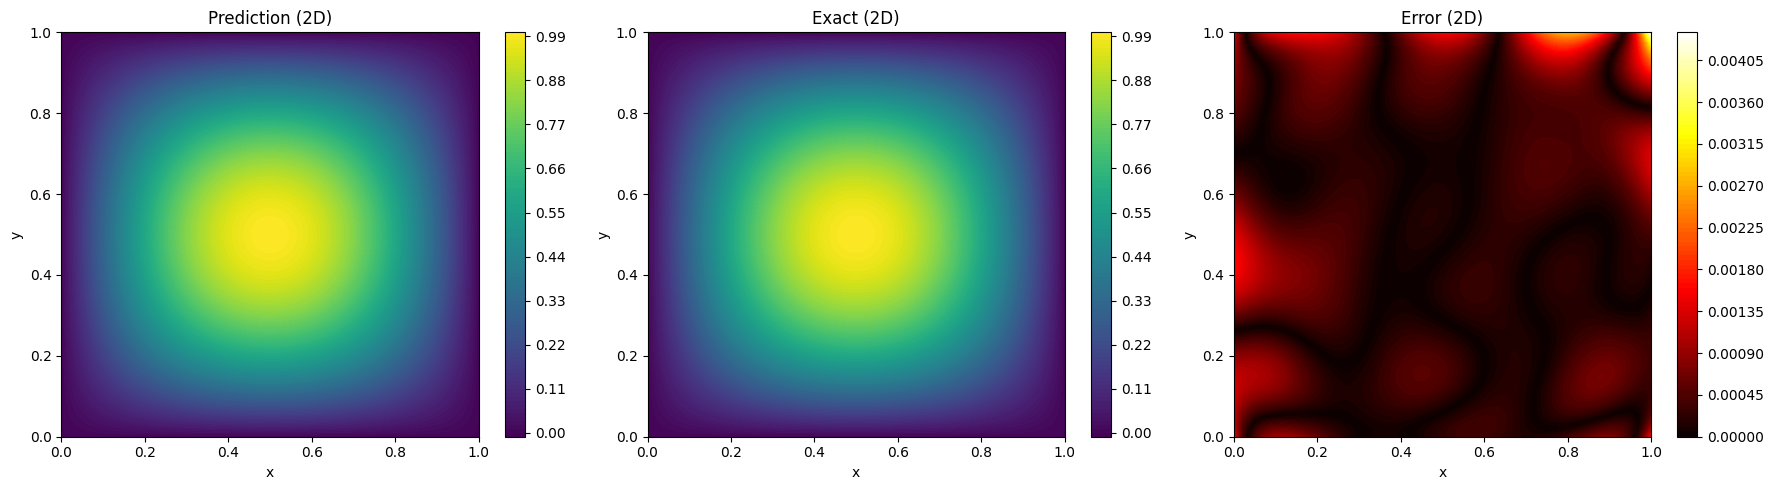

Saved: results/solution_3d_20251116_114542.png


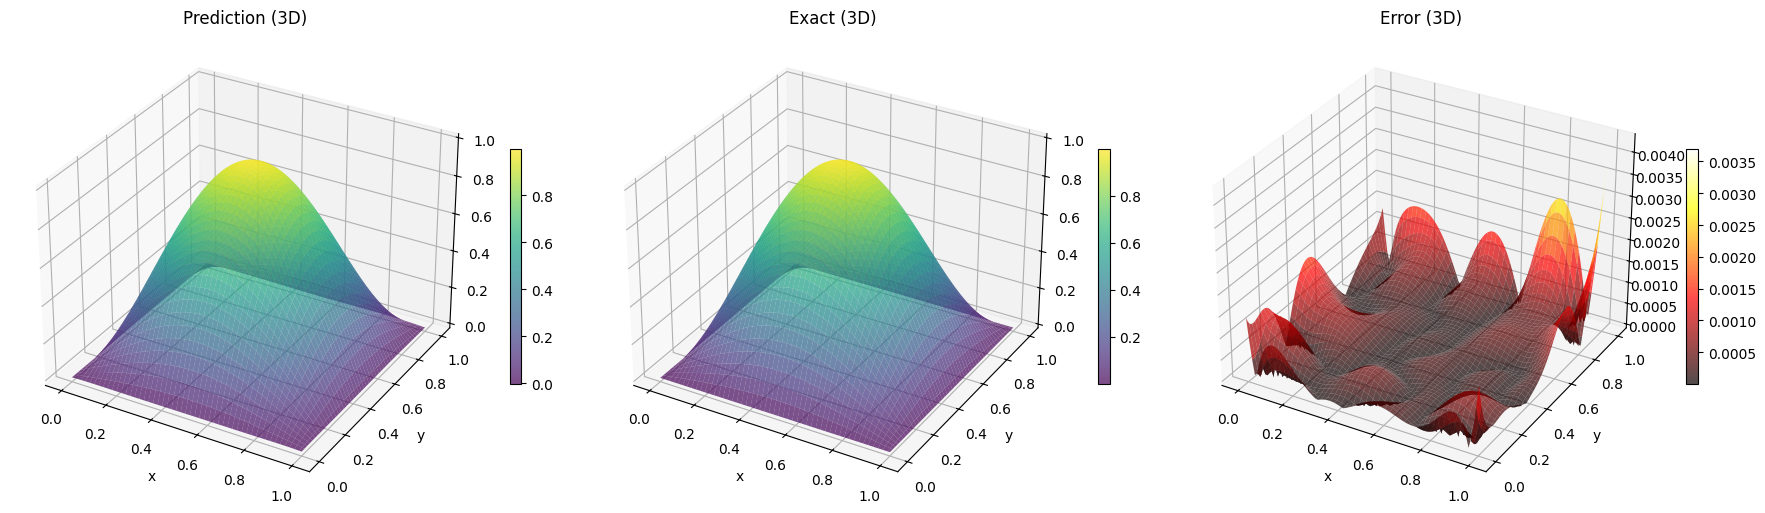

In [34]:
def main():
    cfg = Config()
    set_seed(cfg.seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    model = PINN(hidden_sizes=cfg.layers).to(device)
    data_gen = DataGenerator()
    trainer = Trainer(model, cfg, f_func, g_func, data_gen)
    model, history = trainer.train()

    mse, rel_l2, X, Y, U_pred, U_true = compute_errors(
        model, device, u_exact, return_fields=True
    )
    print(f"MSE = {mse:.3e}, Rel L2 = {rel_l2:.3e}")

    sv = SolutionVisualizer()
    sv.plot_2d(X, Y, U_pred, U_true)
    sv.plot_3d(X, Y, U_pred, U_true)


if __name__ == "__main__":
    main()


## 11. Модуль экспериментов

Сначала организуем еще один `dataclass`, который хранит необходимые метрики по ходу эксперимента. Так как поставленная задача явно включает в себя исследование коэффициента $\lambda_{bc}$, то назовем класс соответственно.

In [33]:
@dataclass
class LambdaRunResult:
    lam_bc: float
    history: any
    mse_final: float
    rel_l2_final: float
    mse_per_epoch: list[float] = field(default_factory=list)
    rel_l2_per_epoch: list[float] = field(default_factory=list)


Теперь создадим базовый класс для проведения одного эксперимента, некоторые методы которого обязаны быть переопределенными в дочерних классах. 

In [35]:
class Experiment(ABC):
    """Абстрактный базовый класс для экспериментов с гиперпараметрами."""
    
    def __init__(self, cfg, model_cls, f_func, g_func, data_gen):
        self.cfg = cfg
        self.model = model_cls(hidden_sizes=cfg.layers).to(cfg.device)
        self.f_func = f_func
        self.g_func = g_func
        self.data_gen = data_gen
        self.history = None
        self.mse_per_epoch = []
        self.rel_l2_per_epoch = []

    def epoch_callback(self, model, epoch):
        """Вызывается на каждой эпохе для сбора метрик."""
        mse, rel_l2 = compute_errors(model, self.cfg.device, u_exact)
        self.mse_per_epoch.append(mse)
        self.rel_l2_per_epoch.append(rel_l2)

    @abstractmethod
    def get_experiment_name(self):
        pass

    @abstractmethod
    def prepare_training_config(self):
        pass

    @abstractmethod
    def create_result(self, history, mse_final, rel_l2_final):
        pass

    def run(self, trainer_cls):
        """Основной метод запуска эксперимента."""
        print(f"\n=== {self.get_experiment_name()} ===")

        # Подготовка конфига для обучения
        training_cfg = self.prepare_training_config()

        # Запуск обучения
        trainer = trainer_cls(
            self.model, training_cfg, self.f_func, self.g_func, self.data_gen
        )
        trained_model, history = trainer.train(epoch_callback=self.epoch_callback)
        self.history = history

        # Снимаем конечные метрики
        mse_final, rel_l2_final = compute_errors(
            trained_model, training_cfg.device, u_exact
        )

        print(f"{self.get_experiment_name()} | mse={mse_final:.3e} | Rel L2={rel_l2_final:.3e}")

        return self.create_result(history, mse_final, rel_l2_final)

Такая реализация позволяет довольно элегантно и понятно реализовать интересующий нас класс `LambdaExperiment(Experiment)`.

In [36]:
class LambdaExperiment(Experiment):
    """
    Эксперимент по изучению влияния весового коэффициента λ
    перед слагаемым с граничными условиями в функции потерь
    на точность и эффективность решения.
    """

    def __init__(self, lam_bc, cfg, model_cls, f_func, g_func, data_gen):
        super().__init__(cfg, model_cls, f_func, g_func, data_gen)
        self.lam_bc = lam_bc

    def get_experiment_name(self):
        return f"LambdaExperiment: λ = {self.lam_bc}"

    def prepare_training_config(self):
        return replace(self.cfg, lam_bc=self.lam_bc)

    def create_result(self, history, mse_final, rel_l2_final):
        """Создает объект результата"""
        return LambdaRunResult(
            lam_bc=self.lam_bc,
            history=history,
            mse_final=mse_final,
            rel_l2_final=rel_l2_final,
            mse_per_epoch=self.mse_per_epoch,
            rel_l2_per_epoch=self.rel_l2_per_epoch,
        )


Метод `create_result` возвращает нам все необходимые данные, которые нужно визуализоровать. Осталось добавь очередной класс для эксперимента в `visualization.py`. 

In [37]:
class LambdaVisualizer(Visualizer):
    """Визуализация экспериментов с λ."""
    
    def plot_results(self, results):
        """Все графики для экспериментов с λ."""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Финальные ошибки
        lambdas = [r.lam_bc for r in results]
        errors = [r.rel_l2_final for r in results]
        axes[0,0].semilogx(lambdas, errors, 'o-', linewidth=2)
        axes[0,0].set_xlabel("λ")
        axes[0,0].set_ylabel("Final L2 Error")
        axes[0,0].grid(True)
        
        # Сходимость по эпохам
        for r in results:
            epochs = range(len(r.rel_l2_per_epoch))
            axes[0,1].semilogy(epochs, r.rel_l2_per_epoch, label=f"λ={r.lam_bc}")
        axes[0,1].legend()
        axes[0,1].set_xlabel("Epoch")
        axes[0,1].set_ylabel("L2 Error")
        axes[0,1].grid(True)
        
        # Потери
        for r in results:
            axes[1,0].semilogy(r.history.total_loss, label=f"λ={r.lam_bc}")
        axes[1,0].legend()
        axes[1,0].set_xlabel("Epoch")
        axes[1,0].set_ylabel("Total Loss")
        axes[1,0].grid(True)
        
        # Соотношение потерь PDE/BC
        for r in results:
            ratio = np.array(r.history.pde_loss) / np.array(r.history.bc_loss)
            axes[1,1].semilogy(ratio, label=f"λ={r.lam_bc}")
        axes[1,1].legend()
        axes[1,1].set_xlabel("Epoch")
        axes[1,1].set_ylabel("PDE/BC Loss Ratio")
        axes[1,1].grid(True)
        
        plt.tight_layout()
        self._save_plot(fig, "lambda_results")
        plt.show()


## 12. Запуск эксперимента

Все готово, осталось собрать воедино все классы, связанные с экспериментом.

Using device: cuda

=== LambdaExperiment: λ = 0.1 ===
[    0] Total=1.007e+02 PDE=1.007e+02 BC=9.223e-03
[ 1000] Total=4.706e+00 PDE=4.111e+00 BC=5.942e+00
[ 2000] Total=2.615e-01 PDE=1.005e-01 BC=1.610e+00
[ 3000] Total=9.072e-02 PDE=3.368e-02 BC=5.704e-01
[ 4000] Total=2.250e-02 PDE=1.111e-02 BC=1.139e-01
[ 5000] Total=5.425e-03 PDE=3.826e-03 BC=1.600e-02
LambdaExperiment: λ = 0.1 | mse=1.108e-02 | Rel L2=2.127e-01

=== LambdaExperiment: λ = 1.0 ===
[    0] Total=9.689e+01 PDE=9.688e+01 BC=9.434e-03
[ 1000] Total=1.411e+00 PDE=7.229e-01 BC=6.877e-01
[ 2000] Total=8.117e-02 PDE=6.405e-02 BC=1.712e-02
[ 3000] Total=4.988e-02 PDE=3.443e-02 BC=1.546e-02
[ 4000] Total=2.986e-02 PDE=1.659e-02 BC=1.327e-02
[ 5000] Total=1.656e-02 PDE=5.285e-03 BC=1.128e-02
LambdaExperiment: λ = 1.0 | mse=3.914e-03 | Rel L2=1.264e-01

=== LambdaExperiment: λ = 10.0 ===
[    0] Total=9.743e+01 PDE=9.742e+01 BC=5.226e-04
[ 1000] Total=8.495e-01 PDE=6.700e-01 BC=1.794e-02
[ 2000] Total=1.717e-01 PDE=5.703e-02 B

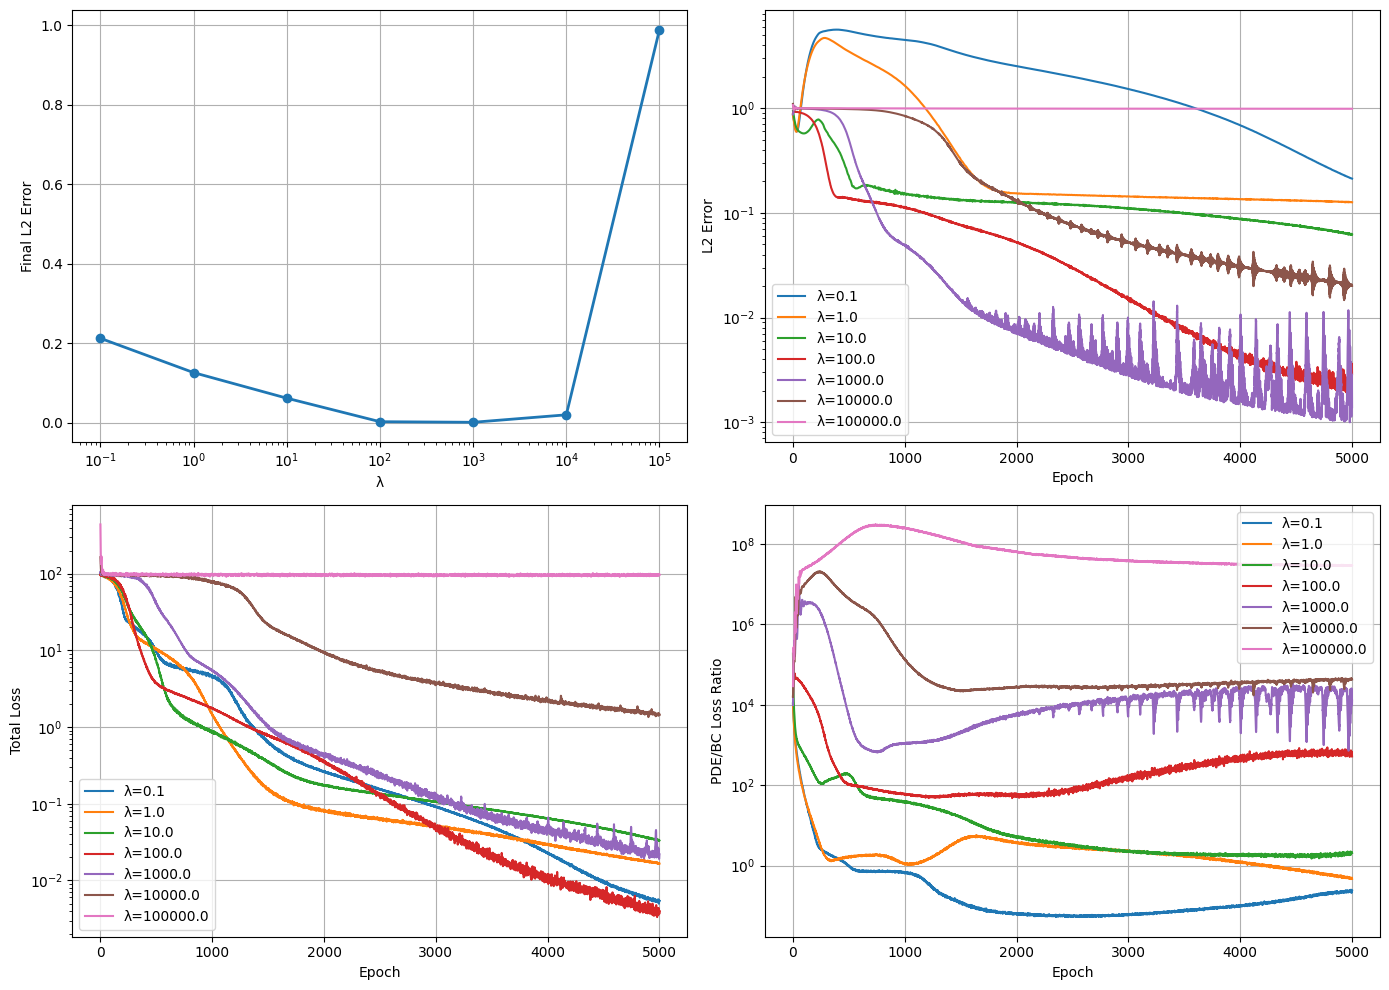

In [38]:
def main():
    cfg = Config()
    set_seed(cfg.seed)
    device = "cuda" if cfg.device == "cuda" else "cpu"
    print(f"Using device: {device}")

    data_gen = DataGenerator()
    model_cls = PINN
    
    lambda_values = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]

    results = []
    for lam in lambda_values:
        exp = LambdaExperiment(
            lam_bc=lam,
            cfg=cfg,
            model_cls=model_cls,
            f_func=f_func,
            g_func=g_func,
            data_gen=data_gen,
        )
        result = exp.run(Trainer)
        results.append(result)

    lv = LambdaVisualizer(base_dir="results")
    lv.plot_results(results)


if __name__ == "__main__":
    main()


## 13. Обсуждение результатов

* Начальная фаза обучения

На начальном этапе обучения ошибки PDE и граничных условий имеют значительную величину. При малых значениях $\lambda_{bc} \leq 1$ наблюдается недостаточное соблюдение граничных условий, что приводит к физически некорректным решениям, даже при удовлетворительном выполнении уравнения. Для $\lambda_{bc} \gg 1$ нейронная сеть в первую очередь обучается удовлетворять граничным условиям, поскольку соответствующий член в функции потерь имеет большой весовой коэффициент. Ошибка на уравнении PDE при этом практически игнорируется, так как ее вклад в общую функцию потерь незначителен по сравнению с сильно взвешенными граничными условиями.

* Промежуточная стадия

Начиная с $\lambda_{bc} = 10 ^ 4$, начинают возникать проблемы в виде осцилляций и больших ошибок. К какому-то моменту ошибка на граничных условиях уменьшается до практически нулевого уровня, и в функции потерь остается только ошибка на уравнении PDE. Далее работает следующий механизм: если нейронная сеть в процессе оптимизации начинает двигаться в направлении, где граничные условия нарушаются, то это приводит к резкому увеличению общего штрафа. Сеть вынуждена возвращаться к состоянию, удовлетворяющему граничным условиям, что и приводит к осцилляциям на графиках.

* Какое $\lambda_{bc}$ выбрать?

Судя по результатам эксперимента и заданной конфигурации модели $\lambda_{bc}^{opt} \in \{\lambda \in \mathbb{R} \mid 10^2 \leq \lambda \leq 10^3\}$.